In [1]:
from glob import glob
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import json
import ntpath
import numpy as np

In [2]:
det_res = json.load(open('0.60.json'))

In [3]:
# the test folder is the path to detection_test
img_list = glob('test/*.jpg')

In [4]:
len(img_list)

1651

In [5]:
det_res[0]

{'image_id': '0001',
 'bbox': [685.50537109375, 378.298828125, 643.368408203125, 356.0216064453125],
 'score': 0.9999505281448364,
 'category_id': 1}

In [6]:
img_list[0]

'test/2467.jpg'

In [7]:
def nms(bbox, threshold=0.8):
    bbox_array = np.array(bbox, dtype=np.float)
    x1 = bbox_array[:, 0]
    y1 = bbox_array[:, 1]
    x2 = bbox_array[:, 2]
    y2 = bbox_array[:, 3]
    scores = bbox_array[:, 4]
    order = scores.argsort()[::-1]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    keep = []

    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        inter = np.maximum(0.0, xx2-xx1+1) * np.maximum(0.0, yy2-yy1+1)
        iou = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(iou <= threshold)[0]
        order = order[inds + 1]
    bbox = bbox_array[keep]
    return bbox

In [8]:
def draw(idx=0, img_list=img_list, det_res=det_res):
    img = cv2.cvtColor(cv2.imread(img_list[idx]), cv2.COLOR_BGR2RGB)
    bboxes = []
    for res in det_res:
        if res['image_id'] != ntpath.basename(img_list[idx])[:-4]: continue
        xywh = list(res['bbox'])
        xyxy = [xywh[0], xywh[1], xywh[0] + xywh[2], xywh[1] + xywh[3]]
        bbox = np.array(xyxy + [res['score']], dtype=np.float)
        bboxes.append(bbox)
    bboxes = nms(bboxes)    
    for xyxy in bboxes:
        xyxy = list(map(int, xyxy))
        img = cv2.rectangle(img, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0,255,0), 3)
    return img

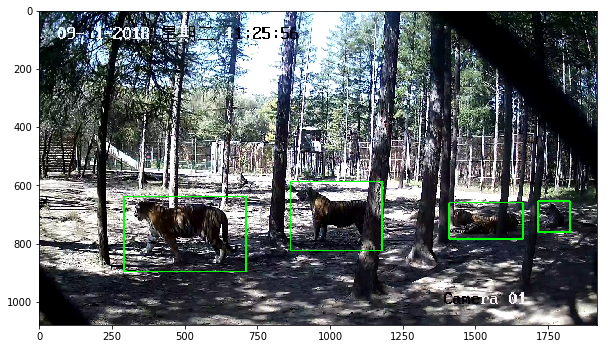

In [18]:
img = draw(1)
fig = plt.figure(figsize=(10, 20))
plt.imshow(img)
plt.show()

In [14]:
def get_bbox(idx=0, img_list=img_list, det_res=det_res):
    bboxes = []
    for res in det_res:
        if res['image_id'] != ntpath.basename(img_list[idx])[:-4]: continue
        xywh = list(res['bbox'])
        xyxy = [xywh[0], xywh[1], xywh[0] + xywh[2], xywh[1] + xywh[3]]
        bbox = np.array(xyxy + [res['score']], dtype=np.float)
        bboxes.append(bbox)
    bboxes = nms(bboxes)
    return bboxes

In [17]:
get_bbox(1)

array([[8.64820007e+02, 5.85056946e+02, 1.18066895e+03, 8.24404541e+02,
        9.99768913e-01],
       [2.92771088e+02, 6.38231262e+02, 7.11666016e+02, 8.96401550e+02,
        9.99603212e-01],
       [1.41157788e+03, 6.59769714e+02, 1.66586523e+03, 7.84157104e+02,
        9.99297857e-01],
       [1.71769263e+03, 6.53035828e+02, 1.82770776e+03, 7.60649536e+02,
        9.97282505e-01]])

In [27]:
for idx, im in enumerate(img_list):
    bboxes = get_bbox(idx)
    img = cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2RGB)
    for bb_idx in range(bboxes.shape[0]):
        bbox = bboxes[bb_idx].astype(np.int)
        crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
        filename = ntpath.basename(im)[:-4] + '_b' + str(bb_idx).zfill(2) \
                    + '_' + str(bbox[0]) + '_' + str(bbox[1]) \
                    + '_' + str(bbox[2] - bbox[0]) + '_' + str(bbox[3] - bbox[1]) + '.jpg'
        cv2.imwrite('test_bb/' + filename, cv2.cvtColor(crop_img, cv2.COLOR_RGB2BGR))